<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro to CNNs and DNNs

### Jonathan Merrill

## Objectives

* Build and train a deep conv net
* Explore and implement various initialization techniques
* Implement a parameterized module in Pytorch
* Use a principled loss function


## Grading Standards:
* 20% Part 0: Successfully followed lab video and typed in code
* 20% Part 1: Re-implement Conv2D and CrossEntropy loss function
* 20% Part 2: Implement different initialization strategies
* 10% Part 3: Print parameters, plot train/test accuracy
* 10% Reach 85% validation accuracy from parts 1-3
* 10% Part 4: Convolution parameters quiz
* 10% Tidy and legible figures, including labeled axes where appropriate
___


In [1]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

___

### Part 1
Re-implement a Conv2D module with parameters and a CrossEntropy loss function.

___

### Part 2
Implement a few initialization strategies which can include Xe initialization
(sometimes called Xavier), Orthogonal initialization, and uniform random.



In [66]:
#parts 1 and 2
# class CrossEntropyLoss(nn.Module):
#   pass
#^ I added cross entropy loss into these classes below and didn't really see the need for a seperate crossentropy class

class Conv2d(nn.Module):
    def __init__(self, n_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, init_method='xe'):
        self.__dict__.update(locals())
        super(Conv2d, self).__init__()
        
        # Initialize weight and bias as parameters
        self.weight = Parameter(torch.Tensor(out_channels,n_channels, *kernel_size))
        self.bias = Parameter(torch.Tensor(out_channels))
        
        # Initialize weights and biases based on the given method
        if init_method == 'uniform':
            self.weight.data.uniform_(-1,1) # uniform initialization between -1 and 1
            self.bias.data.uniform_(0,0) # uniform initialization between 0 and 0
        elif init_method == 'xe':
            torch.nn.init.xavier_normal_(self.weight) # xavier normal initialization
            torch.nn.init.zeros_(self.bias) # zero initialization
        elif init_method == 'orthogonal':
            torch.nn.init.orthogonal_(self.weight) # orthogonal initialization
            torch.nn.init.zeros_(self.bias) # zero initialization
        
    def forward(self, x):
        # Perform convolution operation using the defined weight and bias, along with the given stride, padding, dilation and group values
        return F.conv2d(x,self.weight, self.bias, self.stride, self.padding, self.dilation, self.groups)

     
class ConvNetwork(nn.Module):
    def __init__(self, dataset):
        super(ConvNetwork, self).__init__()
        x, y = dataset[0]
        c, h, w = x.size()
        output = 10

        #create an inordinate amount of deep layers
        self.net = nn.Sequential(
        Conv2d(c, 10, (3,3), padding=(1,1)),
        nn.ReLU(),
        Conv2d(10, 20, (3,3), padding=(1,1)),
        nn.ReLU(),
        Conv2d(20, 30, (3,3), padding=(1,1)),
        nn.ReLU(),
        Conv2d(30, 40, (3,3), padding=(1,1)),
        nn.ReLU(),
        Conv2d(40, 50, (3,3), padding=(1,1)),
        nn.ReLU(),
        Conv2d(50, 60, (3,3), padding=(1,1)),
        nn.ReLU(),
        Conv2d(60, 70, (3,3), padding=(1,1)),
        nn.ReLU(),
        Conv2d(70, 80, (3,3), padding=(1,1)),
        nn.ReLU(),
        Conv2d(80, 90, (3,3), padding=(1,1)),
        nn.ReLU(),
        Conv2d(90, 100, (3,3), padding=(1,1)),
        nn.ReLU(),
        Conv2d(100, 110, (3,3), padding=(1,1)),
        nn.ReLU(),
        Conv2d(110, output, (28,28), padding=(0,0)),
        )

        
    def forward(self, x):
        return self.net(x).squeeze(2).squeeze(2)
    
class FashionMNISTProcessedDataset(Dataset):
    def __init__(self, root, train=True):
        self.data = datasets.FashionMNIST(root, train=train, transform=transforms.ToTensor(), download=True)
        
    def __getitem__(self,i):
        x, y = self.data[i]
        return x,y
        
    def __len__(self):
        return len(self.data)
    
    
# load the train and validation datasets
train_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist')
val_dataset = FashionMNISTProcessedDataset('/tmp/fashionmnist', train=False)

# initialize the model, objective function, and optimizer
model = ConvNetwork(train_dataset)
model = model.cuda()
objective = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-4)

# create data loaders for the train and validation sets
train_loader = DataLoader(train_dataset, batch_size = 64, pin_memory = True)
val_loader = DataLoader(val_dataset, batch_size = 64, pin_memory = True)

# initialize lists to store training information
losses = []
validations = []
accuracies = []

# loop through the training epochs
for epoch in range(1):
    # create a progress bar for the current epoch
    loop = tqdm(total = len(train_loader), position=0, leave=False)
    
    # loop through the batches in the train_loader
    for batch, (x,y_truth) in enumerate(train_loader):
        # move the data to the GPU
        x, y_truth = x.cuda(), y_truth.cuda()
        
        # zero the gradients
        optimizer.zero_grad()
        
        # forward pass
        y_hat = model(x)
        
        # calculate the loss
        loss = objective(y_hat, y_truth)
        
        # backward pass
        loss.backward()
        
        # update the losses, accuracies lists
        losses.append(loss.item())
        with torch.no_grad():
            _, preds = torch.max(y_hat, 1)
            accuracy = torch.mean(torch.eq(preds, y_truth).float()).item()
            accuracies.append(accuracy)

        # update the progress bar with the current loss and accuracy
        loop.set_description('epoch:{}, loss:{:.4f}, accuracy:{:.3f}'.format(epoch, loss, accuracy))
        loop.update(1)
        
        # update the model's parameters
        optimizer.step()
        
        # validate the model every 100 batches
        if batch % 100 == 0:
            val_losses = []
            for x,y in val_loader:
                x, y = x.cuda(), y.cuda()
                y_hat = model(x)
                val_loss = objective(y_hat, y)
                val_losses.append(val_loss.item())
                val = np.mean(val_losses)
            validations.append((len(losses), val))


epoch:0, loss:0.2771, accuracy:0.875: 100%|█████████▉| 937/938 [01:15<00:00, 18.82it/s]


___

### Part 3
Print the number of parameters in your network and plot accuracy of your training and validation 
set over time. You should experiment with some deep networks and see if you can get a network 
with close to 1,000,000 parameters.

Once you've experimented with multiple network setups and the different initialization strategies, plot the best-performing experiment here. You should be able to exceed 85% accuracy on the validation set.


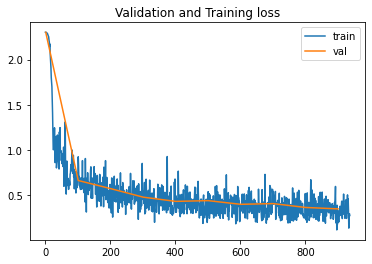

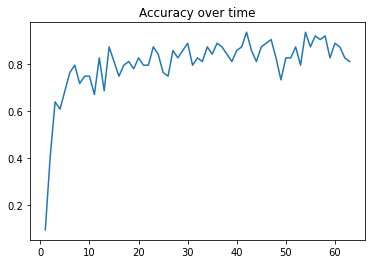

In [72]:
#plot validation and loss
a,b = zip(*validations)
plt.plot(losses, label = 'train')
plt.plot(a,b,label = 'val')
plt.legend()
plt.title("Validation and Training loss")
plt.show()

#plot accuracy
A = accuracies[0::15]
n = np.linspace(1,len(A), len(A))
plt.plot(n, A)  
plt.title("Accuracy over time")
plt.show()

In [76]:
# Compute and print the number of parameters in the model
print("Final Accuracy: ", accuracies[-1]*100, "%")
num_params = sum(p.numel() for p in model.parameters())
print("Number of Parameters: ", num_params)
print("I should also add that I used the xe initialization")

Final Accuracy:  87.5 %
Number of Parameters:  1259160
I should also add that I used the xe initialization


___

### Part 4
Learn about how convolution layers affect the shape of outputs, and answer the following quiz questions. Include these in a new markdown cell in your jupyter notebook.


*Using a Kernel size of 3×3 what should the settings of your 2d convolution be that results in the following mappings (first answer given to you)*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(3, 3), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels=22, kernel_size=(3, 3), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=65, h=12, w=12) : (out_channels=65, kernel_size=(3, 3), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=7, h=20, w=20) : (out_channels=7, kernel_size=(3, 3), padding=(0, 0), stride = (2,2))

*Using a Kernel size of 5×5:*)

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 5), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) : (out_channels=100, kernel_size=(5, 5), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size=(5, 5), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=5, kernel_size=(5, 5), padding=(4, 4), stride=(2, 2))

*Using Kernel size of 5×3:*

* (c=3, h=10, w=10) ⇒ (c=10, h=8, w=8) : (out_channels=10, kernel_size=(5, 3), padding=(1, 0))
* (c=3, h=10, w=10) ⇒ (c=100, h=10, w=10) :(out_channels=100, kernel_size=(5, 3), padding=(0, 1))
* (c=3, h=10, w=10) ⇒ (c=23, h=12, w=12) : (out_channels=23, kernel_size=(5, 3), padding=(1, 1))
* (c=3, h=10, w=10) ⇒ (c=5, h=24, w=24) : (out_channels=5, kernel_size=(5, 3), padding=(4, 2), stride=(2, 2))

*Determine the kernel that requires the smallest padding size to make the following mappings possible:*

* (c=3, h=10, w=10) ⇒ (c=10, h=9, w=7) : (out_channels = 10, kernel_size=(3, 2), padding=(0, 0))
* (c=3, h=10, w=10) ⇒ (c=22, h=10, w=10) : (out_channels = 22, kernel_size=(1, 1), padding=(0, 0))
